In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from tqdm import tqdm

Specifications
---------------

In [2]:
#specifications
input_size = 64
num_channels = 1 #grayscale image
filter_size = 3
filter_stride = 1
pool_size = 2
pool_stride = 2
filter_depth1 = 32
filter_depth2 = 64

fc_layer1 = 1024 #number of neurons in the first fully connected layer
fc_layer2 = 2 #number of output neurons
num_classes = 2 #cat and dog

Image Preprocessing
---------------------

In [3]:
def resize_image(image):
    image = cv2.resize(image,(input_size,input_size),cv2.INTER_CUBIC)
    return image

In [4]:
def get_image_label(image):
    #image is the path to the image
    parts = image.split(".")
    if parts[-3]=="cat":
        return [1,0]
    if parts[-3]=="dog":
        return [0,1]

In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir("data//train")):
        label = get_image_label(img)
        path = os.path.join("data//train",img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = resize_image(img)
        training_data.append([np.array(img),np.array(label)])
    np.random.shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

In [6]:
train_data = create_train_data()
#else load : train_data = np.load(train_data.npy)

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [08:15<00:00, 50.42it/s]


Helper Functions
-----------------

In [40]:
#functions to create new variables
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

In [8]:
#function to create a convolutional layer
#input=[image number,rows,columns,channels]
#output=[image number,r',c',ch']
#layer : conv->relu->pool
def conv_layer(input,num_channels,filter_size,num_filters,use_pooling=True):
    #shape of filters as defined by tensorflow API
    shape = [filter_size,filter_size,num_channels,num_filters]
    weights = new_weights(shape)
    biases = new_biases(num_filters)
    layer = tf.nn.conv2d(input=input,filter=weights,strides=[1,1,1,1],padding='SAME')
    layer+= biases
    layer = tf.nn.relu(layer)
    if use_pooling:
        layer = tf.nn.max_pool(value = layer,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME')
    return layer,weights

In [9]:
#function to flatten 4d tensor
#to feed into fully connected layer
def flatten(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer,[-1,num_features])
    return layer_flat,num_features

In [41]:
def new_fc_layer(input,num_inputs,num_outputs,use_relu=True):
    weights = new_weights(shape = [num_inputs,num_outputs])
    biases = new_biases(length = num_outputs)
    layer = tf.matmul(input,weights)+biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

Model Parameters 
-----------------

In [42]:
x = tf.placeholder(tf.float32,[None,input_size,input_size,num_channels],name='x')
print(x)

Tensor("x_1:0", shape=(?, 64, 64, 1), dtype=float32)


In [43]:
y_true = tf.placeholder(tf.float32,shape = [None,num_classes],name='y_true')
print(y_true)

Tensor("y_true_1:0", shape=(?, 2), dtype=float32)


In [44]:
y_true_class = tf.argmax(y_true,dimension=1,name='y_true_class')
print(y_true_class)

Tensor("y_true_class_1:0", shape=(?,), dtype=int64)


In [45]:
conv1,weights1 = conv_layer(x,num_channels,filter_size,32)
print(conv1)
print(weights1)

Tensor("MaxPool_6:0", shape=(?, 32, 32, 32), dtype=float32)
<tf.Variable 'Variable_16:0' shape=(3, 3, 1, 32) dtype=float32_ref>


In [46]:
conv2,weights2 = conv_layer(conv1,filter_depth1,filter_size,64)
print(conv2)
print(weights2)

Tensor("MaxPool_7:0", shape=(?, 16, 16, 64), dtype=float32)
<tf.Variable 'Variable_18:0' shape=(3, 3, 32, 64) dtype=float32_ref>


In [47]:
conv3,weights3 = conv_layer(conv2,filter_depth2,filter_size,32)
print(conv3)
print(weights3)

Tensor("MaxPool_8:0", shape=(?, 8, 8, 32), dtype=float32)
<tf.Variable 'Variable_20:0' shape=(3, 3, 64, 32) dtype=float32_ref>


In [48]:
conv4,weights4 = conv_layer(conv3,filter_depth1,filter_size,64)
print(conv4)
print(weights4)

Tensor("MaxPool_9:0", shape=(?, 4, 4, 64), dtype=float32)
<tf.Variable 'Variable_22:0' shape=(3, 3, 32, 64) dtype=float32_ref>


In [49]:
conv5,weights5 = conv_layer(conv4,filter_depth2,filter_size,32)
print(conv5)
print(weights5)

Tensor("MaxPool_10:0", shape=(?, 2, 2, 32), dtype=float32)
<tf.Variable 'Variable_24:0' shape=(3, 3, 64, 32) dtype=float32_ref>


In [50]:
conv6,weights6 = conv_layer(conv5,filter_depth1,filter_size,64)
print(conv6)
print(weights6)

Tensor("MaxPool_11:0", shape=(?, 1, 1, 64), dtype=float32)
<tf.Variable 'Variable_26:0' shape=(3, 3, 32, 64) dtype=float32_ref>


In [51]:
#flatten the output of conv6
flat_layer1,num_features = flatten(conv6)
print(flat_layer1)
print(num_features)

Tensor("Reshape_4:0", shape=(?, 64), dtype=float32)
64


In [52]:
#fully connected layer 1
fc1 = new_fc_layer(input = flat_layer1,num_inputs = num_features,num_outputs = fc_layer1)
print(fc1)

Tensor("Relu_14:0", shape=(?, 1024), dtype=float32)


In [53]:
fc2 = new_fc_layer(input = fc1, num_inputs = fc_layer1, num_outputs = fc_layer2)
print(fc2)

Tensor("Relu_15:0", shape=(?, 2), dtype=float32)


In [54]:
#prediction
y_pred = tf.nn.softmax(fc2)
print(y_pred)

Tensor("Softmax_1:0", shape=(?, 2), dtype=float32)


In [55]:
y_pred_cls = tf.argmax(y_pred,dimension=1)
print(y_pred_cls)

Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


In [94]:
#cross entropy loss function
#change this
cross_entropy = -tf.reduce_sum(y_true*tf.log(tf.clip_by_value(y_pred,1e-10,1.0)),1)
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2,labels=y_true)

In [76]:
cost = tf.reduce_mean(cross_entropy)

In [77]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [78]:
correct_prediction = tf.equal(y_pred_cls,y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [70]:
print(len(train_data))
print(len(train_data[0][0][0]))
print(train_data[0][1])

25000
64
[0 1]


In [61]:
train = train_data[:-500]
test = train_data[-500:]
print(len(train))
print(len(test))

24500
500


In [62]:
X = np.array([i[0] for i in train]).reshape(-1,input_size,input_size,1)
Y = np.array([i[1] for i in train])
print(X.shape)
print(Y.shape)
print(len(Y))
test_x = np.array([i[0] for i in test]).reshape(-1,input_size,input_size,1)
test_y = np.array([i[1] for i in test])
print(test_x.shape)
print(Y[0])
print(Y[:3])

(24500, 64, 64, 1)
(24500, 2)
24500
(500, 64, 64, 1)
[0 1]
[[0 1]
 [0 1]
 [1 0]]


Training step
--------------

In [100]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [99]:
batch_size = 128
#128 was good
total_epochs = 0
import time
from datetime import timedelta
def optimize(num_epochs):
    global total_epochs
    start = time.time()
    for i in range(num_epochs):
        for total_iterations in range(300):
            start = (total_iterations*batch_size)%24500
            end = ((total_iterations+1)*batch_size)%24500
            x_batch = X[start:end]
            y_batch = Y[start:end]
            feed_dict_train = {x:x_batch,y_true:y_batch}
            session.run(optimizer,feed_dict = feed_dict_train)
            
            if total_iterations%50 == 0:
                acc = session.run(accuracy,feed_dict = feed_dict_train)
                msg = "Optimization iteration:{0:>6}, Training Accuracy:{1:>6.1%}"
                print(msg.format(total_iterations+1,acc))
        total_epochs+=1
        end = time.time()
        print("Time usage:"+str(timedelta(seconds=int(round(end-start)))))

In [101]:
optimize(1)

Optimization iteration:     1, Training Accuracy: 51.6%
Optimization iteration:    51, Training Accuracy: 54.7%
Optimization iteration:   101, Training Accuracy: 57.8%
Optimization iteration:   151, Training Accuracy: 68.8%
Optimization iteration:   201, Training Accuracy: 68.8%
Optimization iteration:   251, Training Accuracy: 68.8%
Time usage:17416 days, 2:00:37


In [102]:
total_epochs

1

In [103]:
optimize(2)

Optimization iteration:     1, Training Accuracy: 72.7%
Optimization iteration:    51, Training Accuracy: 66.4%
Optimization iteration:   101, Training Accuracy: 71.1%
Optimization iteration:   151, Training Accuracy: 72.7%
Optimization iteration:   201, Training Accuracy: 76.6%
Optimization iteration:   251, Training Accuracy: 75.0%
Time usage:17416 days, 2:12:08
Optimization iteration:     1, Training Accuracy: 72.7%
Optimization iteration:    51, Training Accuracy: 78.1%
Optimization iteration:   101, Training Accuracy: 80.5%
Optimization iteration:   151, Training Accuracy: 75.0%
Optimization iteration:   201, Training Accuracy: 80.5%
Optimization iteration:   251, Training Accuracy: 80.5%
Time usage:17416 days, 2:22:46


In [104]:
#test for validation accuracy
val_dict = {x:test_x,y_true:test_y}
acc = session.run(accuracy,feed_dict = val_dict)
print("validation accuracy:%f"%(acc))

validation accuracy:0.728000


In [105]:
optimize(2)

Optimization iteration:     1, Training Accuracy: 75.0%
Optimization iteration:    51, Training Accuracy: 78.1%
Optimization iteration:   101, Training Accuracy: 81.2%
Optimization iteration:   151, Training Accuracy: 74.2%
Optimization iteration:   201, Training Accuracy: 83.6%
Optimization iteration:   251, Training Accuracy: 84.4%
Time usage:17416 days, 2:37:39
Optimization iteration:     1, Training Accuracy: 76.6%
Optimization iteration:    51, Training Accuracy: 84.4%
Optimization iteration:   101, Training Accuracy: 82.8%
Optimization iteration:   151, Training Accuracy: 75.0%
Optimization iteration:   201, Training Accuracy: 84.4%
Optimization iteration:   251, Training Accuracy: 87.5%
Time usage:17416 days, 2:47:54


In [106]:
#test for validation accuracy
val_dict = {x:test_x,y_true:test_y}
acc = session.run(accuracy,feed_dict = val_dict)
print("validation accuracy:%f"%(acc))

validation accuracy:0.746000


In [107]:
total_epochs

5

In [108]:
optimize(3)

Optimization iteration:     1, Training Accuracy: 78.1%
Optimization iteration:    51, Training Accuracy: 87.5%
Optimization iteration:   101, Training Accuracy: 86.7%
Optimization iteration:   151, Training Accuracy: 76.6%
Optimization iteration:   201, Training Accuracy: 85.9%
Optimization iteration:   251, Training Accuracy: 89.8%
Time usage:17416 days, 2:58:37
Optimization iteration:     1, Training Accuracy: 84.4%
Optimization iteration:    51, Training Accuracy: 88.3%
Optimization iteration:   101, Training Accuracy: 89.8%
Optimization iteration:   151, Training Accuracy: 78.1%
Optimization iteration:   201, Training Accuracy: 87.5%
Optimization iteration:   251, Training Accuracy: 92.2%
Time usage:17416 days, 3:08:43
Optimization iteration:     1, Training Accuracy: 84.4%
Optimization iteration:    51, Training Accuracy: 90.6%
Optimization iteration:   101, Training Accuracy: 92.2%
Optimization iteration:   151, Training Accuracy: 75.8%
Optimization iteration:   201, Training Ac

In [109]:
#test for validation accuracy
val_dict = {x:test_x,y_true:test_y}
acc = session.run(accuracy,feed_dict = val_dict)
print("validation accuracy:%f"%(acc))

validation accuracy:0.734000


In [110]:
#create saver to save the model
saver = tf.train.Saver()

In [111]:
total_epochs

8

Saving the model
------------------

In [114]:
saver.save(session,'model\\my_model.tfm',global_step = 2400)

'model\\my_model.tfm-2400'

More helper functions
---------------------

In [127]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir("data//test1")):
        path = os.path.join("data//test1",img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (input_size,input_size))
        testing_data.append([np.array(img), img_num])
    np.random.shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [128]:
test_data = process_test_data()

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [03:13<00:00, 64.45it/s]


In [139]:
def predict(pred_batch):
    feed_dict = {x:pred_batch}
    pred_cls = session.run(y_pred_cls,feed_dict = feed_dict)
    return pred_cls

In [130]:
print(test_data[0])

[array([[118, 118, 123, ..., 130,  97,  99],
       [124, 129, 126, ..., 142, 113, 100],
       [125, 122, 122, ..., 146, 139, 153],
       ..., 
       [174, 171, 177, ...,  81,  82,  91],
       [178, 176, 175, ...,  96,  74, 114],
       [173, 172, 176, ...,  87,  96, 120]], dtype=uint8), '10223']


Making Predictions
--------------------

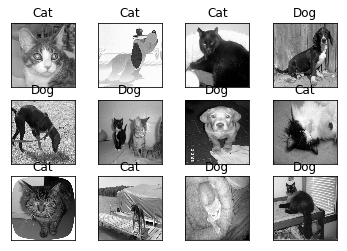

In [145]:
fig = plt.figure()

for num,data in enumerate(test_data[:12]):
    #cat:[1,0]
    #dog:[0,1]
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    orig = orig.reshape(input_size,input_size,1)
    model_out = predict([orig])
    if model_out == 1: str_label='Dog'
    else: str_label='Cat'
    y.imshow(img_data,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Create submission file
-----------------------

In [149]:
with open('predictions.csv','w') as f:
    f.write('id,label\n')
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        orig = orig.reshape(input_size,input_size,1)
        model_out = predict([orig])
        f.write('{},{}\n'.format(img_num,model_out[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:46<00:00, 117.72it/s]
